In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:
def load_data(filename):
    ## Let's load the dataset
    if ".csv" not in filename:
        filename=filename+".csv"
    df1=pd.read_csv(filename,parse_dates=True,index_col=["Time"])
    return df1

In [3]:
## As you can see all the values in our dataframe is string let's convert it into floating point value
def parse_columns(x):
    try:
        return np.float32(x)
    except:
        return np.float32(x.replace(",",""))

In [4]:
def preprocess_data(df):
    df = df.replace(['-'],'0')
    for col in df.columns:
        df[col]=df[col].apply(lambda x : parse_columns(x))
    return df

In [5]:
def plot_data(df):
    plt.figure(figsize=(10,20))
    plt.subplot(3,1,1)
    plt.plot(df["Pi [psi]"],label="Intake Pressure Psi")
    plt.plot(df["Pd [psi]"],label="Discharge Pressure Psi")
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(df["Ti [Deg F]"],label="Intake Temperature in C")
    plt.plot(df["Tm [Deg F]"],label="Motor Temperature in C")
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(df["I_MOTOR"],label="SYS Current in mA")
    plt.plot(df["V_MOTOR"],label="Avg VSD in mA")
    plt.plot(df["MOT_FREQ"],label="Frequency Hz")
    plt.legend()

In [6]:
#plot_data(df1)

In [7]:
def scale_data(df):
    sc=StandardScaler()
    cols=df.columns
    inds=df.index
    values=sc.fit_transform(df)
    return pd.DataFrame(values,columns=cols,index=inds), sc

In [8]:
def perform_pca(df,n_components):
    pca=PCA(n_components=n_components)
    pca.fit(df)
    plt.bar(x=range(1,n_components+1),height=pca.explained_variance_ratio_,color="grey")
    plt.xticks(range(1,n_components+1),[f"PCA{n}" for n in range(1,n_components+1)])
    plt.title("Explained variance Ratio",fontsize=12)
    return pca,pca.transform(df)

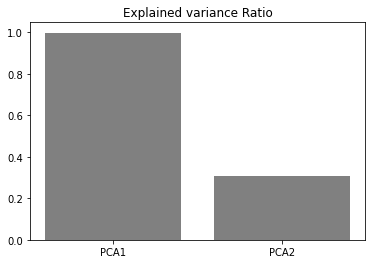

In [9]:
for x in range(1,15):
    filename = f"Well {x}.csv"
    df1=load_data(filename)
    df1=preprocess_data(df1)
    df2 = df1
    df1.drop('WHP [psi]', axis='columns', inplace=True)
    df1.drop('V_MOTOR', axis='columns', inplace=True)
    df1.drop('VIBRATION', axis='columns', inplace=True)
    df1.drop('FLP [psi]', axis='columns', inplace=True)
    df1,scalar=scale_data(df1)
    pca,df1_pca=perform_pca(df1,2)
    detector=IsolationForest(contamination=0.01,random_state=0)## You could choose any value between 0 and 1 according to % of outlier
    detector.fit(df1_pca)
    prediction=detector.predict(df1_pca)
    dfdb = pd.DataFrame(df1_pca, columns = ['PCA1','PCA2'])
    dfdb.index = df2.index
    dfdb["Anomoly"]=prediction
    df2 = load_data(f"Well {x} with predictions")
    df_final = pd.concat([df2, dfdb], axis=1)
    df_final.to_csv(f"Well {x} with PCA.csv")

In [ ]:
df1_pca

In [17]:
times=df1.index
t = [mdates.date2num(datetime.strptime(str(i), "%Y-%m-%d %H:%M:%S")) for i in times]

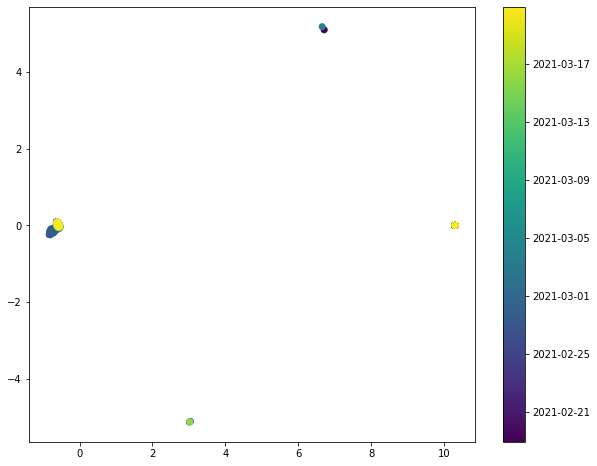

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(df1_pca[:,0],df1_pca[:,1], c=t[:])

loc = mdates.AutoDateLocator()
fig.colorbar(sc, ticks=loc,format=mdates.AutoDateFormatter(loc))

IsolationForest(contamination=0.01, random_state=0)

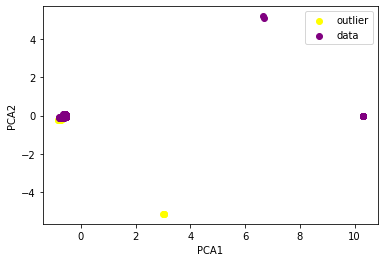

In [21]:
plt.scatter(df1_pca[:-1,0][prediction[:-1]==-1],df1_pca[:-1,1][prediction[:-1]==-1],label="outlier",color="yellow")
plt.scatter(df1_pca[:-1,0][prediction[:-1]==1],df1_pca[:-1,1][prediction[:-1]==1],label="data",color="purple")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

In [49]:
print(df1)

                    WHP [psi] FLP [psi] I_MOTOR   V_MOTOR MOT_FREQ Pi [psi]  \
Time                                                                          
2021-02-18 21:57:00    196.13    187.96    55.2  3,242.72       50   676.58   
2021-02-18 22:07:00    198.25    189.84   54.76  3,242.72    49.99   675.98   
2021-02-18 22:17:00     195.8     187.4   54.96  3,244.46    50.02   675.39   
2021-02-18 22:27:00    197.05    188.79   54.77  3,244.46    50.01   675.33   
2021-02-18 22:37:00    200.51    191.64    55.4  3,244.46    49.99   675.35   
...                       ...       ...     ...       ...      ...      ...   
2021-03-20 21:17:00    194.41     185.9    55.5  3,244.46    49.99   669.46   
2021-03-20 21:27:00    194.49    186.29   55.12  3,242.72    50.03    669.5   
2021-03-20 21:37:00    193.06    184.48    54.8  3,243.59    50.02   668.97   
2021-03-20 21:47:00    193.58    184.98   55.46  3,243.59       50   669.01   
2021-03-20 21:57:00         -         -       -     

In [67]:
# Save the model and our pca 
import pickle
with open("Model.pkl","wb") as f:
    pickle.dump(detector,f)
with open("PCA_Transform.pkl","wb") as f:
    pickle.dump(pca,f)
with open("Scalar.pkl","wb") as f:
    pickle.dump(scalar,f)

In [68]:
import csv
import json

In [69]:
csvFilePath = 'simulated_data.csv'
jsonFilePath = 'simulated_data.json'
data = {}

In [70]:
# Convert the csv to JSON
x = 1
with open(csvFilePath) as csvFile:
    csvReader = csv.DictReader(csvFile)
    for csvRow in csvReader:
        rowid = x
        data[rowid] = csvRow
        x = x+1

with open(jsonFilePath,'w') as jsonFile:
    jsonFile.write(json.dumps(data, indent=4))

In [71]:
# Load the JSON file
with open('simulated_data.json') as dataFile:
    data = json.load(dataFile)


In [72]:
data["1"]

{'Drive Frequency': '52.9',
 'Average Amps': '38.5',
 'Discharge Pressure': '652.41',
 'Intake Pressure': '1370.95',
 'Intake Temperature': '61.9',
 'Motor Temperature': '84.8'}

In [73]:
data

{'1': {'Drive Frequency': '52.9',
  'Average Amps': '38.5',
  'Discharge Pressure': '652.41',
  'Intake Pressure': '1370.95',
  'Intake Temperature': '61.9',
  'Motor Temperature': '84.8'},
 '2': {'Drive Frequency': '52.9',
  'Average Amps': '37.9',
  'Discharge Pressure': '652.41',
  'Intake Pressure': '1370.95',
  'Intake Temperature': '61.9',
  'Motor Temperature': '84.8'},
 '3': {'Drive Frequency': '52.9',
  'Average Amps': '37.9',
  'Discharge Pressure': '652.98',
  'Intake Pressure': '1370.81',
  'Intake Temperature': '61.9',
  'Motor Temperature': '84.8'},
 '4': {'Drive Frequency': '52.9',
  'Average Amps': '37.9',
  'Discharge Pressure': '652.55',
  'Intake Pressure': '1369.96',
  'Intake Temperature': '61.9',
  'Motor Temperature': '84.9'},
 '5': {'Drive Frequency': '52.9',
  'Average Amps': '37.9',
  'Discharge Pressure': '651.98',
  'Intake Pressure': '1370.67',
  'Intake Temperature': '61.9',
  'Motor Temperature': '84.8'},
 '6': {'Drive Frequency': '52.9',
  'Average Amps'

In [74]:
def UpdatePredictionPlot():
    pass
    # add the point to the plot containing all previous readings as times series + Mark any outlier points
    # YOUR CODE HERE

In [75]:
# load the pretrained model 
with open("Model.pkl","rb") as f:
    detector=pickle.load(f)
with open("PCA_Transform.pkl","rb") as f:
    pca=pickle.load(f)
with open("Scalar.pkl","rb") as f:
    scalar=pickle.load(f)

In [76]:
predictions=[]
for i in range(1,len(data)+1):
    df_json = data[f'{i}']
    # convert the df_json into a dataframe. add a simulated date and time like in the dataframe we used for training. make sure the coloums are in the order as the dataframe used in training.
    #.... you can get the data like this: data['1']['Drive Frequency']
    # predict whether the point is an outlier or not and then call UpdatePredictionPlot() to update the plot
    
    rows=pd.Series(df_json)[["Average Amps","Drive Frequency","Intake Pressure","Discharge Pressure","Intake Temperature","Motor Temperature"]].values
    rows=np.array(rows,dtype="float32").reshape(1,-1)
    print(detector.predict(pca.transform(scalar.transform(rows)))) 
    predictions.append(detector.predict(pca.transform(scalar.transform(rows)))[0])

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[-1]
[-1]
[1]
[-1]
[-1]
[-1]
[-1]
[1]
[1]
[1]
[1]
[1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[1]
[1]
[1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1

In [77]:
data=pd.DataFrame(data).T[["Average Amps","Drive Frequency","Intake Pressure","Discharge Pressure","Intake Temperature","Motor Temperature"]]

In [78]:
scaled_data=scalar.transform(data)

In [79]:
pca_data=pca.transform(scaled_data)

In [80]:
dates=pd.date_range(start="2021-04-20",end="2021-04-22",periods=713)

AttributeError: 'DatetimeIndex' object has no attribute 'describe'

In [81]:
t = [mdates.date2num(datetime.strptime(str(i).split(".")[0], "%Y-%m-%d %H:%M:%S")) for i in dates]

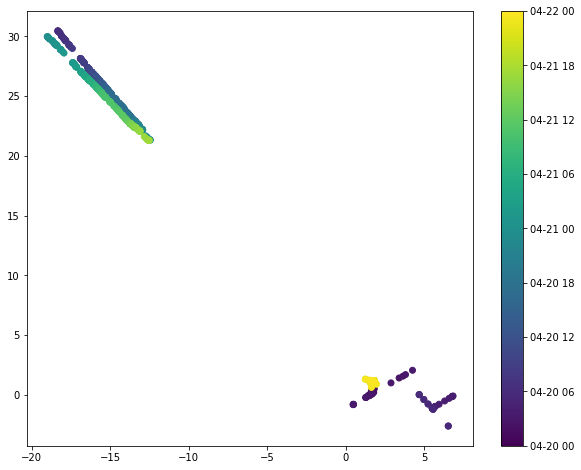

In [82]:
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(pca_data[:,0],pca_data[:,1], c=t[:])

loc = mdates.AutoDateLocator()
fig.colorbar(sc, ticks=loc,format=mdates.AutoDateFormatter(loc))

In [106]:
df10=pd.read_csv(csvFilePath)
df000 = load_data("Well 6 with predictions.csv")

In [107]:
df10.index = df000[:713].index

In [118]:
df10

,Drive Frequency,Average Amps,Discharge Pressure,Intake Pressure,Intake Temperature,Motor Temperature
Time,,,,,,
2021-02-18 21:57:00,52.9,38.5,652.41,1370.95,61.9,84.8
2021-02-18 22:07:00,52.9,37.9,652.41,1370.95,61.9,84.8
2021-02-18 22:17:00,52.9,37.9,652.98,1370.81,61.9,84.8
2021-02-18 22:27:00,52.9,37.9,652.55,1369.96,61.9,84.9
2021-02-18 22:37:00,52.9,37.9,651.98,1370.67,61.9,84.8
...,...,...,...,...,...,...
2021-02-23 19:57:00,60.1,39.6,680.00,1154.70,61.8,109.7
2021-02-23 20:07:00,60.2,39.6,703.47,1157.60,61.9,110.3
2021-02-23 20:17:00,60.2,39.6,703.47,1156.80,61.9,110.4


In [122]:
df_finalPCA = pd.DataFrame(pca_data, columns = ['PCA1','PCA2'])
df_finalPCA.index = df10.index
df_final2 = pd.concat([df10, df_finalPCA], axis=1)
df_final2["Anomaly"] = predictions[:713]
# print(df_final2)

In [123]:
df_final2

,Drive Frequency,Average Amps,Discharge Pressure,Intake Pressure,Intake Temperature,Motor Temperature,PCA1,PCA2,Anomaly
Time,,,,,,,,,
2021-02-18 21:57:00,52.9,38.5,652.41,1370.95,61.9,84.8,1.694561,0.468903,1
2021-02-18 22:07:00,52.9,37.9,652.41,1370.95,61.9,84.8,1.714084,0.440459,1
2021-02-18 22:17:00,52.9,37.9,652.98,1370.81,61.9,84.8,1.714214,0.440572,1
2021-02-18 22:27:00,52.9,37.9,652.55,1369.96,61.9,84.9,1.715763,0.441815,1
2021-02-18 22:37:00,52.9,37.9,651.98,1370.67,61.9,84.8,1.715028,0.441166,1
...,...,...,...,...,...,...,...,...,...
2021-02-23 19:57:00,60.1,39.6,680.00,1154.70,61.8,109.7,1.739704,1.158624,1
2021-02-23 20:07:00,60.2,39.6,703.47,1157.60,61.9,110.3,1.711366,1.145953,1
2021-02-23 20:17:00,60.2,39.6,703.47,1156.80,61.9,110.4,1.712593,1.146962,1


In [124]:
#df10["predictions"] = predictions
df_final2.to_csv("Simulated_data_with_PCA.csv")

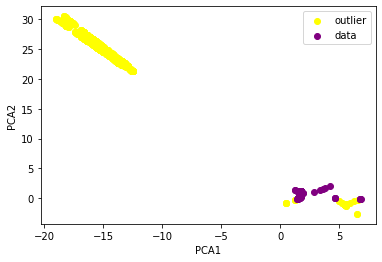

In [125]:
predictions=np.array(predictions)
plt.scatter(pca_data[:,0][predictions==-1],pca_data[:,1][predictions==-1],label="outlier",color="yellow")
plt.scatter(pca_data[:,0][predictions==1],pca_data[:,1][predictions==1],label="data",color="purple")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()